In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import re, glob


# Plot CPU times for IMEX-RB on 2D nonlinear problem
We study CPU times on the 2D viscous Burgers equation

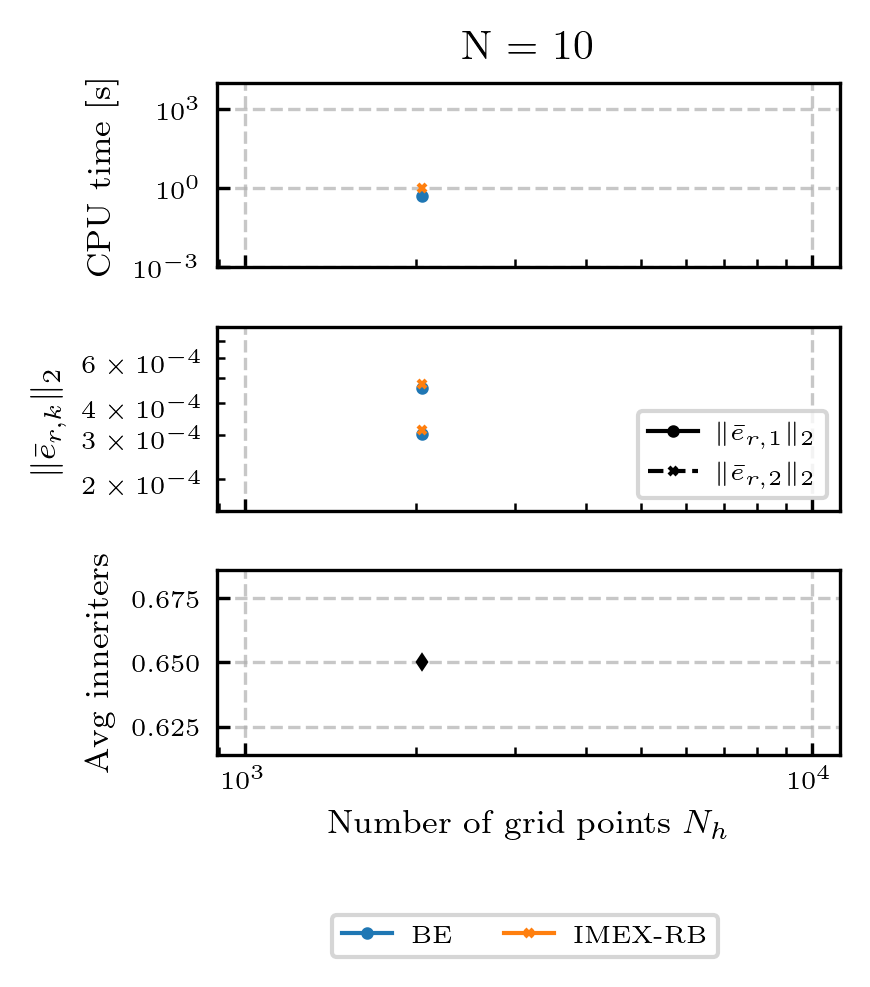

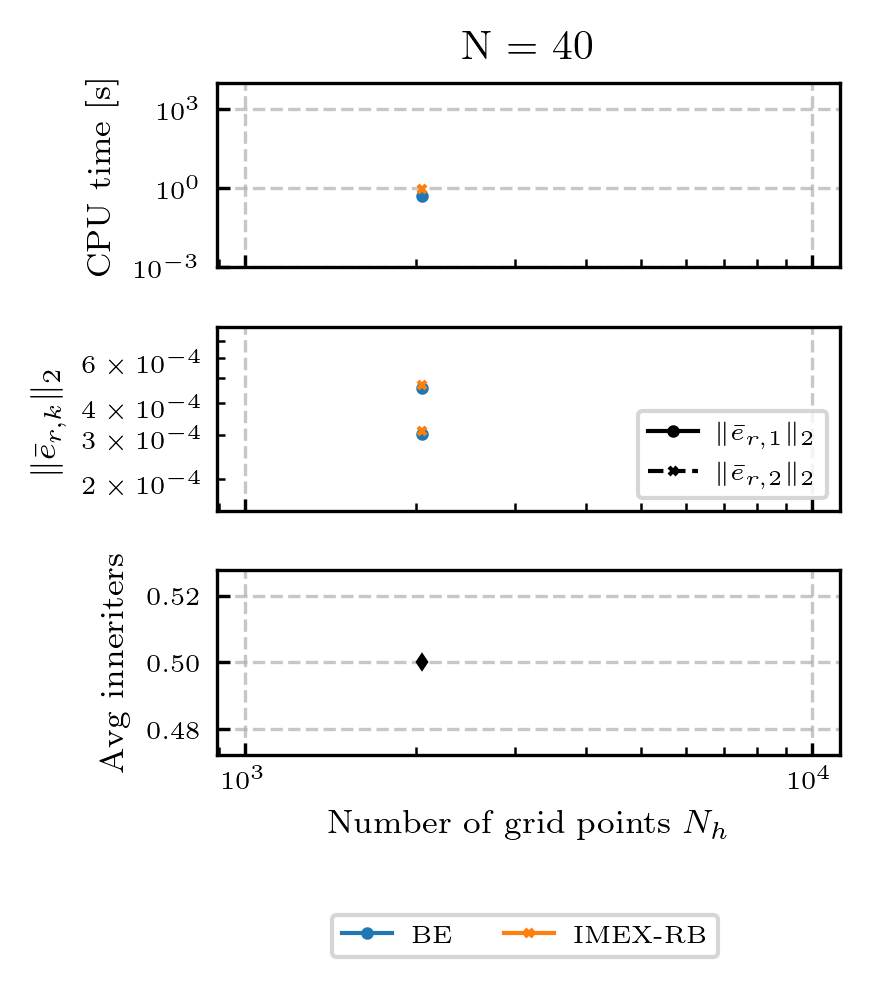

In [6]:
# Retrieve data
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))

# Paths
problem_name = "Burgers2D"
test_name = "CPUtimes"
# Find results
results_base = os.path.join(base_dir, os.pardir, os.pardir, 'results', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')

plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
times = data['times'].item()
errors_l2 = data['errors_l2'].item()
Nh_values = data['Nh_values']
N_values = data['N_values']
inneriters = data['inneriters'].item()['IMEX-RB']

methods = ['BE', 'IMEX-RB']
methods_labels = ['BE', 'IMEX-RB']
methods_marker = ['o', 'x']


# Set transparency level for all plots
plot_alpha = 1

# Create plots for each N value
for n_idx, N_val in enumerate(N_values):
    # Create subplot grid: 3 rows, 1 column
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(3, 3), sharex=True)
    
    # First row: CPU times
    for ctr_m, m in enumerate(methods):
        if m == 'IMEX-RB':
            # For IMEX-RB, use the specific N_val data
            ax1.loglog(Nh_values, times[m][n_idx], marker=methods_marker[ctr_m], 
                      label=methods_labels[ctr_m])
        else:
            # For BE and FE, use the same data for all N values
            ax1.loglog(Nh_values, times[m], marker=methods_marker[ctr_m], 
                      label=methods_labels[ctr_m])
    
    ax1.set_ylabel('CPU time [s]')
    ax1.set_ylim((1e-3, 1e4))
    ax1.set_title(f'N = {N_val}')
    
    # Second row: L2 errors with single y-axis
    # Plot both components for each method
    for m in methods:
        if m == 'IMEX-RB':
            # Component 1 (solid line)
            ax2.loglog(Nh_values, errors_l2[m][n_idx][0], marker=methods_marker[1], linestyle='-', 
                       color='C0' if m == 'BE' else 'C1')
            # Component 2 (dashed line)
            ax2.loglog(Nh_values, errors_l2[m][n_idx][1], marker=methods_marker[1], linestyle='--', 
                       color='C0' if m == 'BE' else 'C1')
        else:
            # For BE, use the same data for all N values
            # Component 1 (solid line)
            ax2.loglog(Nh_values, errors_l2[m][0], marker=methods_marker[0], linestyle='-', 
                       color='C0' if m == 'BE' else 'C1')
            # Component 2 (dashed line)
            ax2.loglog(Nh_values, errors_l2[m][1], marker=methods_marker[0], linestyle='--', 
                       color='C0' if m == 'BE' else 'C1')

    ax2.set_ylabel(r'$\|\bar{e}_{r,k}\|_2$')
    ax2.set_ylim((1.5e-4, 8e-4))

    # Third row: Average sub-iterations (only for IMEX-RB)
    ax3.semilogx(Nh_values, np.mean(inneriters[n_idx], axis=1), color='k', marker='d', linestyle="-")
    ax3.set_ylabel(fr'Avg inneriters')
    ax3.set_xlabel('Number of grid points $N_h$')

    # Create custom legend entries for the error plot
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='k', marker=methods_marker[0], linestyle='-', label=r'$\|\bar{e}_{r,1}\|_2$'),
        Line2D([0], [0], color='k', marker=methods_marker[1], linestyle='--', label=r'$\|\bar{e}_{r,2}\|_2$')
    ]
    ax2.legend(handles=legend_elements, loc='lower right')

    # Main legend for methods (from first plot)
    fig.legend(methods_labels, bbox_to_anchor=(0.6, -0.02), loc='upper center', ncol=3)
    plt.tight_layout()
    
    # Save each plot with N value in filename
    out_file = os.path.join(
        plots_dir, f'Burgers2D_cputimes_errors_N{N_val}.pdf'
    )
    plt.savefig(out_file, bbox_inches='tight')
    plt.show()
    plt.close()